In [11]:
import os
import torch

from torchinfo import summary

import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim import SGD
import torch.nn.functional as F

from mobiface_like_v1 import MobiFace

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler

import numpy as np
from sklearn.metrics import roc_curve
from itertools import islice
from facenet_pytorch import InceptionResnetV1

from backbone import get_model  
#import model


import random

In [12]:
# Set a random seed for reproducibility
seed = 42
torch.manual_seed(seed)

# If using GPU, also set the seed for GPU
torch.cuda.manual_seed_all(seed)


In [13]:
import torch
import torchvision.models as models



In [15]:
# Load a pre-trained ResNet model

teacher_v3 = get_model(name="r50",fp16 = True)
teacher_v3_state_dict = torch.load('backbone.pth')
teacher_v3.load_state_dict(teacher_v3_state_dict)


<All keys matched successfully>

In [16]:

# Set the model to evaluation mode
teacher_v3.eval()

IResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu): PReLU(num_parameters=64)
  (layer1): Sequential(
    (0): IBasicBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): IBas

In [17]:
summary(teacher_v3, (1,3,112,112))

Layer (type:depth-idx)                   Output Shape              Param #
IResNet                                  [1, 512]                  --
├─Conv2d: 1-1                            [1, 64, 112, 112]         1,728
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─PReLU: 1-3                             [1, 64, 112, 112]         64
├─Sequential: 1-4                        [1, 64, 56, 56]           --
│    └─IBasicBlock: 2-1                  [1, 64, 56, 56]           --
│    │    └─BatchNorm2d: 3-1             [1, 64, 112, 112]         128
│    │    └─Conv2d: 3-2                  [1, 64, 112, 112]         36,864
│    │    └─BatchNorm2d: 3-3             [1, 64, 112, 112]         128
│    │    └─PReLU: 3-4                   [1, 64, 112, 112]         64
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-6             [1, 64, 56, 56]           128
│    │    └─Sequential: 3-7              [1, 64, 56, 56]           4,2

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
teacher_v3.to(device)

IResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu): PReLU(num_parameters=64)
  (layer1): Sequential(
    (0): IBasicBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): IBas

In [20]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [21]:
# directory for test
root_dir= "C:\\Users\\mathe\\OneDrive\\Área de Trabalho\\master\\TFM\\dataset\\faces_webface_112x112\\images"


batch_size = 64

# Create ImageFolder dataset
dataset = datasets.ImageFolder(root=root_dir, transform=transform)

# Number of images for testing
num_test_images = 2000

# Total number of images
total_images = len(dataset)

# Indices of images for testing
test_indices = random.sample(range(total_images), num_test_images)

# Remaining indices for validation and training
remaining_indices = set(range(total_images)) - set(test_indices)


# Split remaining indices into validation and training sets
remaining_indices = list(remaining_indices)
random.shuffle(remaining_indices)


# Define the sizes of validation and training sets
val_size = int(0.20 * len(remaining_indices))
train_size = len(remaining_indices) - val_size

# Indices for validation and training sets
val_indices = remaining_indices[:val_size]
train_indices = remaining_indices[val_size:]


# Create Subset datasets
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)
train_dataset = Subset(dataset, train_indices)

# Create DataLoader for training, validation, and testing
batch_size = 1  # Set batch size to 1 since we are loading images one by one
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)



In [22]:
inputs_total = []
labels_total = []
for inputs, labels in islice(train_loader,32):
    inputs, labels = inputs.to(device), labels.to(device)
    labels_total.append(labels)
    inputs_total.append(inputs)

In [23]:
teacher_v3.eval()
def cosine_similarity(embeddings1, embeddings2):
    dot_product = torch.dot(embeddings1, embeddings2)
    norm_embeddings1 = torch.norm(embeddings1)
    norm_embeddings2 = torch.norm(embeddings2)
    return dot_product / (norm_embeddings1 * norm_embeddings2)

In [24]:
teacher_v3(inputs_total[0])[0]

tensor([ 6.4700e-01, -8.6291e-01, -1.5013e+00,  1.1498e+00,  4.7663e-01,
         6.6772e-01, -1.5855e+00,  2.4835e+00, -1.1238e-02,  1.4175e-01,
        -3.5896e-01, -1.3470e+00, -5.5508e-02, -1.4361e+00,  2.2967e-01,
        -9.1561e-01, -5.4569e-01,  2.6437e-02,  1.1064e+00,  3.5333e-01,
        -1.7159e-01,  5.9577e-01, -1.4192e+00, -8.7209e-01, -1.0552e+00,
        -6.7445e-01, -1.8191e-01, -1.3717e+00,  2.2893e-01, -1.5803e+00,
         1.1899e+00, -5.0261e-01, -7.9661e-01,  8.8856e-01,  2.1518e+00,
        -1.3726e+00,  2.1747e-01, -9.0205e-01,  1.3400e+00, -4.0391e-01,
         4.7069e-01, -1.0682e-01,  2.2890e-01,  2.0530e+00, -2.0913e+00,
        -5.3229e-01,  1.1924e+00, -8.4685e-01, -1.4730e+00, -2.4607e-01,
        -1.0149e+00, -2.8657e+00,  9.9612e-01, -7.1916e-01,  8.1711e-02,
         1.0414e+00,  1.6963e-01,  3.3473e-01, -5.0473e-01, -2.9362e-01,
        -1.0862e+00,  8.6684e-01,  5.4883e-01, -2.1451e+00,  5.5166e-01,
        -8.5023e-01, -1.8821e+00,  9.6899e-01,  2.5

In [25]:
cosine_similarity(teacher_v3(inputs_total[0])[0],teacher_v3(inputs_total[1])[0])

tensor(0.0565, device='cuda:0', grad_fn=<DivBackward0>)

In [26]:
teacher= teacher_v3

In [27]:



embeddings = []  # List to store embeddings
labels_list = []  # List to store labels
comparison_similarity = []

teacher.eval()
for images,labels in test_loader:
    with torch.no_grad():
        outputs = teacher(images.to(device))
    embeddings.append(outputs.to(device))
    labels_list.append(labels.to(device))


embeddings = torch.cat(embeddings, dim=0)
labels_list = torch.cat(labels_list, dim=0)

# Prepare labels for pairwise similarity scores (1 for same person, 0 for different people)
pairwise_labels = []
comparisons_label = []
for i, (images1, label1) in enumerate(test_loader):
    for j, (images2, label2) in enumerate(test_loader):
        if j > i:  # Only consider pairs where j > i to avoid duplicate pairs and pairs with the same image
            if label1 == label2:
                pair_label = 1  # Same person
            else:
                pair_label = 0  # Different people
            pairwise_labels.append(pair_label)
            comparisons_label.append([pair_label,label1,label2])

# Convert pairwise labels to a tensor
pairwise_labels_tensor = torch.tensor(pairwise_labels, device=device)


similarities = []
for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        similarity = cosine_similarity(embeddings[i], embeddings[j])
        comparison_similarity.append([similarity,labels_list[i],labels_list[j]])
        similarities.append(similarity)

similarities_tensor = torch.tensor(similarities, device=device)

In [28]:
# Compute ROC curve

#fpr, tpr, thresholds = roc_curve(pairwise_labels_tensor.cpu().numpy(), similarities_tensor.cpu().numpy())
fpr, tpr, thresholds = roc_curve(pairwise_labels_tensor.cpu().numpy(), similarities_tensor.cpu().numpy())


# Move thresholds to CUDA

thresholds_tensor = torch.tensor(thresholds, device=device)


# Convert fpr and tpr to PyTorch tensors

fpr_tensor = torch.tensor(fpr, device=device)
tpr_tensor = torch.tensor(tpr, device=device)


# Calculate EER
eer_threshold = thresholds_tensor[torch.argmin(torch.abs(fpr_tensor - (1 - tpr_tensor)))]
eer = (fpr_tensor[torch.argmin(torch.abs(fpr_tensor - (1 - tpr_tensor)))] + (1 - tpr_tensor)[torch.argmin(torch.abs(fpr_tensor - (1 - tpr_tensor)))]) / 2

print("Equal Error Rate (EER):", eer)

Equal Error Rate (EER): tensor(0.0641, device='cuda:0', dtype=torch.float64)


In [29]:
thresholds_tensor

tensor([    inf,  0.8647,  0.6328,  ..., -0.2321, -0.2321, -0.3697],
       device='cuda:0')

In [30]:
len(np.unique(np.array(labels_list.cpu())))

1605

In [31]:
eer_threshold 

tensor(0.1129, device='cuda:0')

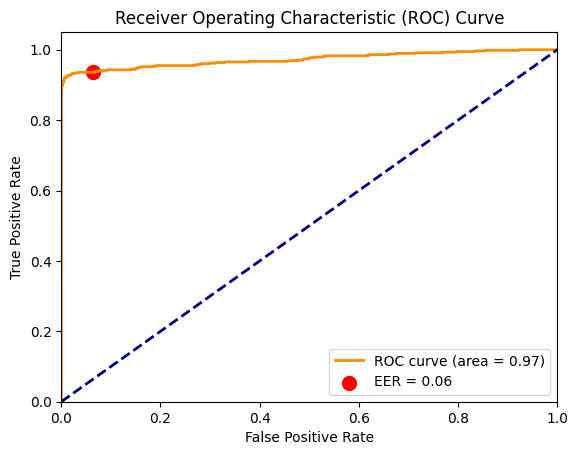

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot EER point
plt.scatter(fpr_tensor[torch.argmin(torch.abs(fpr_tensor.cpu() - (1 - tpr_tensor.cpu())))].cpu(), 
            tpr_tensor[torch.argmin(torch.abs(fpr_tensor.cpu() - (1 - tpr_tensor.cpu())))].cpu(), 
            s=100, c='red', marker='o', label='EER = %0.2f' % eer)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()